# Sunspot Cycle & 3D Surface Reconstruction

#### Team members: Areeba Hashmi, Hifza Ijaz, Denis Boborukhin, Skoltech, 2025


## Part I: Approximating the 11-year Sunspot Cycle

### 1: Load monthly mean sunspot data
- Columns: year, month, monthly mean sunspot number

In [41]:
import numpy as np
import matplotlib.pyplot as plt

data_path = 'data/data_group5.txt'
sunspot_data = np.loadtxt(data_path)

years = sunspot_data[:,0].astype(int)
months = sunspot_data[:,1].astype(int)
sunspot_numbers = sunspot_data[:,2]


### 2: Apply 13-month running mean smoothing
Formula:
$
\bar{R}_i = \frac{1}{24} R_{i-6} + \frac{1}{12} \sum_{j=-5}^{5} R_{i+j} + \frac{1}{24} R_{i+6}
$

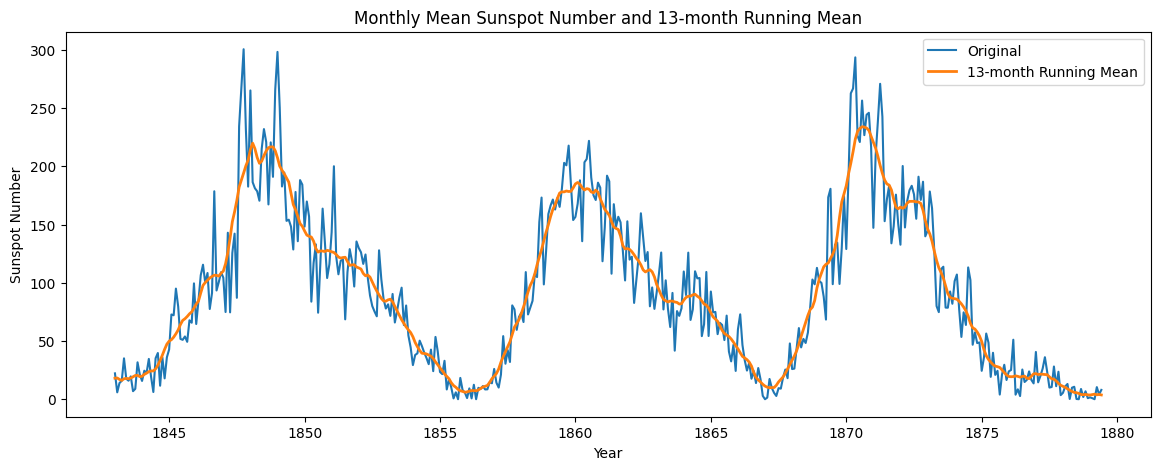

In [42]:
def running_mean_13month(data):
    n = len(data)
    smoothed = np.empty(n)
    for i in range(n):
        if i < 6:
            smoothed[i] = np.mean(data[:i+7])
        elif i > n - 7:
            smoothed[i] = np.mean(data[i-6:])
        else:
            smoothed[i] = (data[i-6]/24 + np.sum(data[i-5:i+6])/12 + data[i+6]/24)
    return smoothed

sunspot_smoothed_13mo = running_mean_13month(sunspot_numbers)

# Plot original and smoothed data
dates = years + (months - 1) / 12.0
plt.figure(figsize=(14,5))
plt.plot(dates, sunspot_numbers, label='Original')
plt.plot(dates, sunspot_smoothed_13mo, label='13-month Running Mean', linewidth=2)
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Monthly Mean Sunspot Number and 13-month Running Mean')
plt.legend()
plt.show()

### 3: Forward-backward exponential smoothing
Apply forward-backward exponential smoothing to the original monthly sunspot values.
Compare results with the 13-month running mean using deviation and variability indicators.
Try different smoothing constants \(\alpha\).

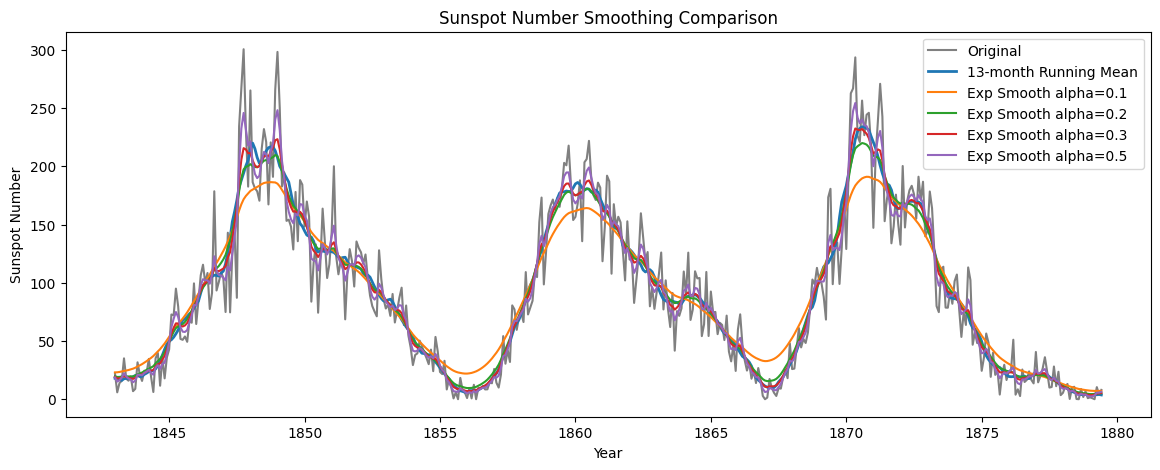

13-month running mean: MAD = 16.340, Variability = 4173.481
Exp smoothing alpha=0.1: MAD = 20.176, Variability = 2977.652
Exp smoothing alpha=0.2: MAD = 15.986, Variability = 3888.755
Exp smoothing alpha=0.3: MAD = 14.240, Variability = 4156.747
Exp smoothing alpha=0.5: MAD = 11.219, Variability = 4380.988


In [43]:
def forward_exp_smooth(data, alpha):
    smoothed = np.zeros_like(data)
    smoothed[0] = data[0]
    for i in range(1, len(data)):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i-1]
    return smoothed

def backward_exp_smooth(data, alpha):
    smoothed = np.zeros_like(data)
    smoothed[-1] = data[-1]
    for i in range(len(data)-2, -1, -1):
        smoothed[i] = alpha * data[i] + (1 - alpha) * smoothed[i+1]
    return smoothed

def forward_backward_exp_smooth(data, alpha):
    forward = forward_exp_smooth(data, alpha)
    backward = backward_exp_smooth(forward, alpha)
    return backward

alphas = [0.1, 0.2, 0.3, 0.5]
plt.figure(figsize=(14,5))
plt.plot(dates, sunspot_numbers, label='Original', color='grey')
plt.plot(dates, sunspot_smoothed_13mo, label='13-month Running Mean', linewidth=2)
for alpha in alphas:
    smoothed_exp = forward_backward_exp_smooth(sunspot_numbers, alpha)
    plt.plot(dates, smoothed_exp, label=f'Exp Smooth alpha={alpha}')
plt.xlabel('Year')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Number Smoothing Comparison')
plt.legend()
plt.show()

def compute_stats(original, smoothed):
    diff = original - smoothed
    deviation = np.mean(np.abs(diff))
    variability = np.var(smoothed)
    return deviation, variability

dev_13mo, var_13mo = compute_stats(sunspot_numbers, sunspot_smoothed_13mo)
print(f"13-month running mean: MAD = {dev_13mo:.3f}, Variability = {var_13mo:.3f}")

for alpha in alphas:
    smoothed_exp = forward_backward_exp_smooth(sunspot_numbers, alpha)
    dev, var = compute_stats(sunspot_numbers, smoothed_exp)
    print(f"Exp smoothing alpha={alpha}: MAD = {dev:.3f}, Variability = {var:.3f}")

## Part II: 3D Surface Reconstruction Under Noise

In [44]:
surface_folder = 'data/'
noisy_surface = np.loadtxt(surface_folder + 'noisy_surface.txt')
true_surface = np.loadtxt(surface_folder + 'true_surface.txt')
print('Noisy surface shape:', noisy_surface.shape)
print('True surface shape:', true_surface.shape)

Noisy surface shape: (51, 51)
True surface shape: (51, 51)


### 2: Plot both surfaces with colorbars

In [45]:
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting

def plot_3d_surface(surface, title):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111, projection='3d')
    rows, cols = surface.shape
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))
    surf = ax.plot_surface(X, Y, surface, cmap='viridis', edgecolor='none')
    ax.set_title(title)
    ax.set_xlabel('X (Column Index)')
    ax.set_ylabel('Y (Row Index)')
    ax.set_zlabel('Surface Value')
    fig.colorbar(surf, shrink=0.5, aspect=10)
    plt.show()


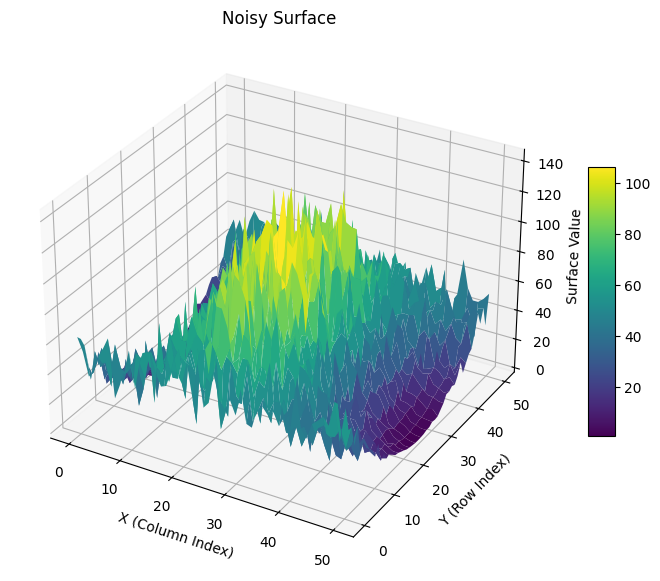

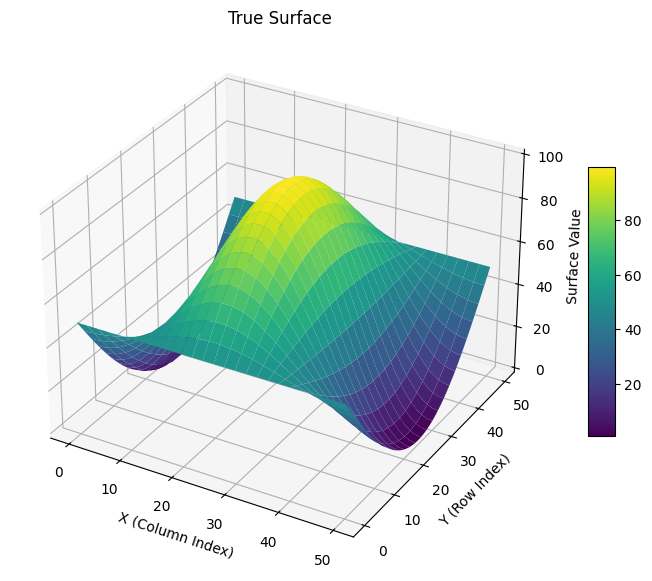

In [46]:

plot_3d_surface(noisy_surface, 'Noisy Surface')
plot_3d_surface(true_surface, 'True Surface')

### 3: Calculate variance of deviation between noisy and true surfaces

In [47]:
deviation_noisy = noisy_surface - true_surface
variance_noisy = np.var(deviation_noisy.reshape(-1))
print(f"Variance of deviation: {variance_noisy:.6f}")

Variance of deviation: 120.577620


### 4: Forward-backward exponential smoothing on noisy surface \(\alpha=0.335\)

In [48]:
alpha = 0.335

def exp_smooth_1d(arr, alpha, forward=True):
    n = len(arr)
    smoothed = np.zeros_like(arr)
    if forward:
        smoothed[0] = arr[0]
        for i in range(1, n):
            smoothed[i] = alpha * arr[i] + (1 - alpha) * smoothed[i-1]
    else:
        smoothed[-1] = arr[-1]
        for i in range(n-2, -1, -1):
            smoothed[i] = alpha * arr[i] + (1 - alpha) * smoothed[i+1]
    return smoothed

def forward_backward_smooth_2d(surface, alpha):
    rows, cols = surface.shape
    temp1 = np.zeros_like(surface)
    for r in range(rows):
        temp1[r,:] = exp_smooth_1d(surface[r,:], alpha, forward=True)
    temp2 = np.zeros_like(surface)
    for r in range(rows):
        temp2[r,:] = exp_smooth_1d(temp1[r,:], alpha, forward=False)
    temp3 = np.zeros_like(surface)
    for c in range(cols):
        temp3[:,c] = exp_smooth_1d(temp2[:,c], alpha, forward=True)
    temp4 = np.zeros_like(surface)
    for c in range(cols):
        temp4[:,c] = exp_smooth_1d(temp3[:,c], alpha, forward=False)
    return temp4

smoothed_surface = forward_backward_smooth_2d(noisy_surface, alpha)

### Task 5: Visualize smoothed surface and true surface

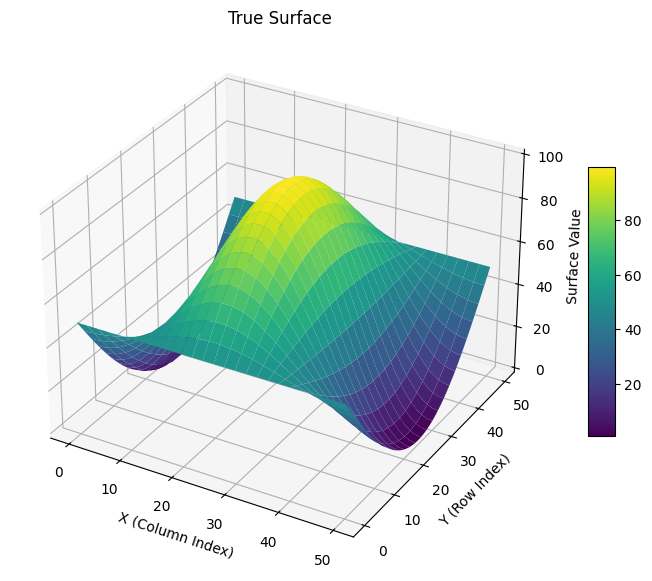

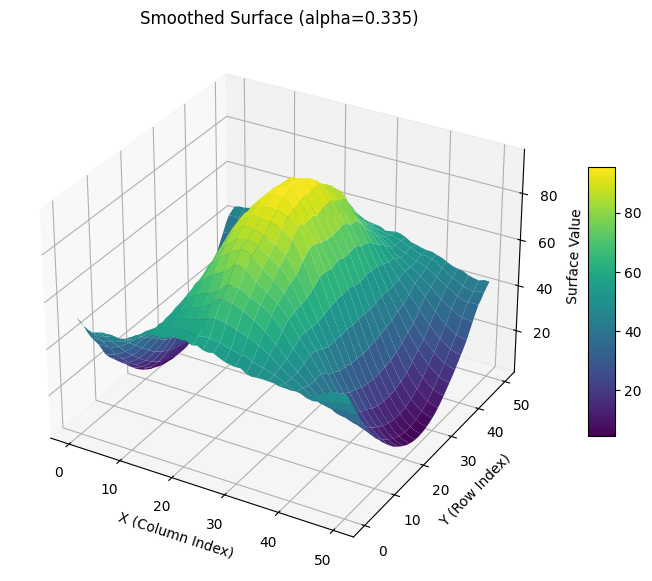

In [49]:
plot_3d_surface(true_surface, 'True Surface')
plot_3d_surface(smoothed_surface, 'Smoothed Surface (alpha=0.335)')

### Task 6: Calculate variance of deviation between smoothed and true surfaces

In [54]:
deviation_smoothed = smoothed_surface - true_surface
variance_smoothed = np.var(deviation_smoothed.reshape(-1))
print(f"Variance of deviation for smoothed: {variance_smoothed:.6f}")
print(f"Variance reduction by smoothing: {variance_noisy - variance_smoothed:.6f}")

Variance of deviation for smoothed: 7.072717
Variance reduction by smoothing: 113.504903


### Task 7: Effect of varying smoothing constant \(\alpha\)
Try values smaller and greater than 0.335 and discuss the effect on smoothing.

alpha =    0.1: Variance of deviation = 238.352497
alpha =    0.2: Variance of deviation = 45.206446
alpha =    0.3: Variance of deviation = 10.571221
alpha =  0.335: Variance of deviation = 7.072717
alpha =    0.4: Variance of deviation = 4.366719
alpha =    0.5: Variance of deviation = 4.577336
alpha =    0.6: Variance of deviation = 7.802797
alpha =    0.7: Variance of deviation = 14.644298
alpha =    0.9: Variance of deviation = 56.715611


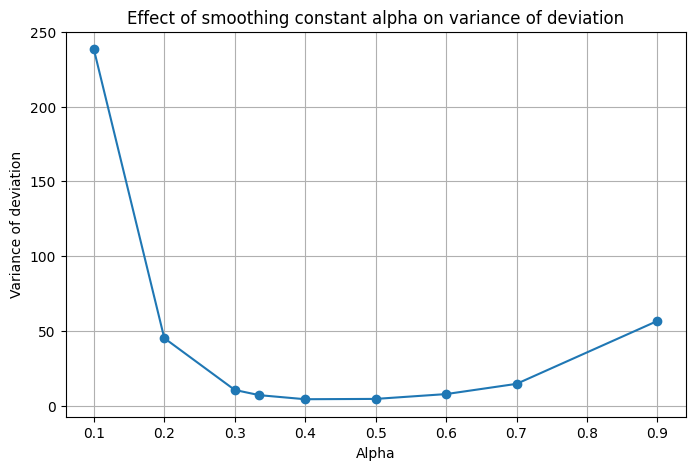

Effect of alpha:
- Smaller alpha results in stronger smoothing, reducing noise but potentially blurring features.
- Larger alpha preserves data features but less noise reduction.
- Optimal alpha balances noise reduction with feature preservation.


In [59]:
alpha_values = [0.1, 0.2, 0.3, 0.335, 0.4, 0.5, 0.6, 0.7, 0.9]
variances = []
for a in alpha_values:
    smooth = forward_backward_smooth_2d(noisy_surface, a)
    deviation = smooth - true_surface
    var = np.var(deviation.reshape(-1))
    variances.append(var)
    print(f"alpha = {a:6}: Variance of deviation = {var:.6f}")

plt.figure(figsize=(8,5))
plt.plot(alpha_values, variances, marker='o')
plt.title('Effect of smoothing constant alpha on variance of deviation')
plt.xlabel('Alpha')
plt.ylabel('Variance of deviation')
plt.grid(True)
plt.show()

print("Effect of alpha:\n- Smaller alpha results in stronger smoothing, reducing noise but potentially blurring features.\n- Larger alpha preserves data features but less noise reduction.\n- Optimal alpha balances noise reduction with feature preservation.")